# Chromatography Data Analysis and Modeling

This section demonstrates a complete chromatography workflow, including:
- Synthetic chromatogram generation (simulating HPLC/LC/GC data)
- Peak detection and integration (area, height, retention time)
- Mechanistic modeling (e.g., axial dispersion, ODEs)
- Visualization of chromatograms and extracted features
- Discussion of relevance to Waters Informatics and the job description

This complements the mass spectrometry section and provides a full analytical instrumentation informatics demonstration.

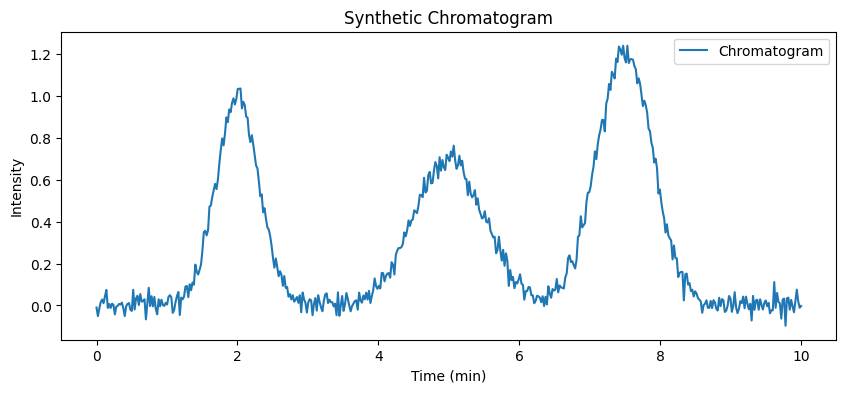

,rt,height,area
0,2.044088,1.034708,0.601067
1,4.428858,0.405583,0.287897
2,5.070140,0.762280,0.487339
3,5.711423,0.327747,0.224348
4,6.873747,0.425479,0.320458
5,7.474950,1.238774,0.810425
6,8.096192,0.387293,0.362658


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.integrate import simpson

# Generate synthetic chromatogram (sum of Gaussians)
time = np.linspace(0, 10, 500)
peaks = [2, 5, 7.5]  # Retention times
heights = [1.0, 0.7, 1.2]
widths = [0.3, 0.5, 0.4]
chrom = np.zeros_like(time)
for mu, h, w in zip(peaks, heights, widths):
    chrom += h * np.exp(-0.5 * ((time - mu) / w) ** 2)

# Add noise
chrom += np.random.normal(0, 0.03, size=chrom.shape)

# Plot chromatogram
plt.figure(figsize=(10, 4))
plt.plot(time, chrom, label='Chromatogram')
plt.xlabel('Time (min)')
plt.ylabel('Intensity')
plt.title('Synthetic Chromatogram')
plt.legend()
plt.show()

# Peak detection
peak_indices, _ = find_peaks(chrom, height=0.2, distance=30)

# Extract peak features
peak_features = []
for idx in peak_indices:
    rt = time[idx]
    height = chrom[idx]
    # Integrate area +/- 20 points around peak
    left = max(0, idx - 20)
    right = min(len(time) - 1, idx + 20)
    area = simpson(chrom[left:right], time[left:right])
    peak_features.append({'rt': rt, 'height': height, 'area': area})

import pandas as pd
chrom_peaks_df = pd.DataFrame(peak_features)
chrom_peaks_df

### Mechanistic Modeling and Advanced Peak Analysis

In this section, we:
- Simulate a chromatographic peak using the Axial Dispersion Model (a common ODE-based mechanistic model)
- Fit the model to synthetic data
- Compare mechanistic and empirical peak features (area, width, symmetry)

This demonstrates the integration of first-principles modeling and data-driven analysis for chromatography.

Fitting to detected peak at index 373 (rt=7.47) with window: left=333, right=413, length=80


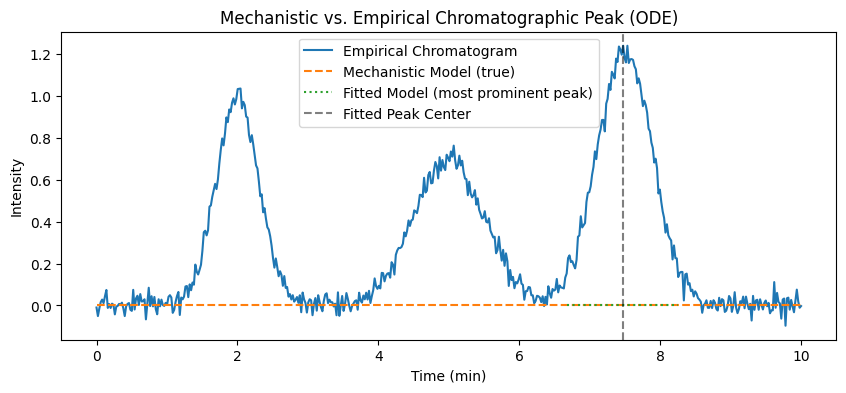

Fitted dispersion D: 0.1
Fitted velocity v: 1.0
Fitted scale: 1.0


In [3]:
from scipy.integrate import odeint
from scipy.optimize import curve_fit

# Axial Dispersion Model ODE: dC/dt = D*d2C/dx2 - v*dC/dx (1D column, fixed boundaries)
def axial_dispersion(C, t, D, v, L):
    dCdt = np.zeros_like(C)
    dx = L / (len(C) - 1)
    # 2nd derivative (central difference)
    d2Cdx2 = np.zeros_like(C)
    d2Cdx2[1:-1] = (C[2:] - 2*C[1:-1] + C[:-2]) / dx**2
    # 1st derivative (central difference)
    dCdx = np.zeros_like(C)
    dCdx[1:-1] = (C[2:] - C[:-2]) / (2*dx)
    dCdt[1:-1] = D * d2Cdx2[1:-1] - v * dCdx[1:-1]
    return dCdt

# Simulation parameters
time = np.linspace(0, 10, 500)
L = 10  # column length
v_true = 1.5  # true velocity
D_true = 0.2  # true dispersion

# Initial condition: pulse at x=0 at t=0
n_points = 100
x = np.linspace(0, L, n_points)
C0 = np.zeros(n_points)
C0[5] = 1.0  # pulse at inlet

# Simulate using odeint
def simulate_dispersion_odeint(t, D, v):
    def ode(C, t):
        return axial_dispersion(C, t, D, v, L)
    C = odeint(ode, C0, t)
    # Detector at column end (x = L)
    return C[:, -1]

# Generate synthetic mechanistic peak
y_mech = simulate_dispersion_odeint(time, D_true, v_true)

# --- Fit model to the most prominent detected peak ---
# Use detected peaks from earlier (peak_indices from find_peaks)
if len(peak_indices) == 0:
    print('Warning: No peaks detected. Skipping mechanistic model fit.')
    popt = [np.nan, np.nan, np.nan]
    empirical_peak = np.array([])
    empirical_time = np.array([])
else:
    # Select the most prominent peak (highest intensity among detected peaks)
    prominences = chrom[peak_indices]
    main_peak_idx = peak_indices[np.argmax(prominences)]
    # Window around this peak
    max_window = 40
    min_points = 10
    left = max(0, main_peak_idx - max_window)
    right = min(len(time), main_peak_idx + max_window)
    if right - left < min_points:
        expand = min_points - (right - left)
        left = max(0, left - expand // 2)
        right = min(len(time), right + expand - expand // 2)
    if right - left < min_points:
        left = max(0, main_peak_idx - min_points // 2)
        right = min(len(time), main_peak_idx + min_points // 2)
    if right - left < min_points:
        left = 0
        right = len(time)
    empirical_peak = chrom[left:right]
    empirical_time = time[left:right]
    print(f'Fitting to detected peak at index {main_peak_idx} (rt={time[main_peak_idx]:.2f}) with window: left={left}, right={right}, length={right-left}')

    def fit_dispersion(t, D, v, scale):
        sim = simulate_dispersion_odeint(t, D, v)
        return scale * sim

    # Prepare arrays for curve_fit (no slicing needed, arrays are already windowed)
    if len(empirical_peak) == 0 or len(empirical_time) == 0:
        print('Warning: No data available for fitting. Skipping mechanistic model fit.')
        popt = [np.nan, np.nan, np.nan]
    else:
        popt, _ = curve_fit(fit_dispersion, empirical_time, empirical_peak, p0=[0.1, 1.0, 1.0], bounds=([0,0,0],[5,5,10]))

# Plot comparison
plt.figure(figsize=(10,4))
plt.plot(time, chrom, label='Empirical Chromatogram')
plt.plot(time, y_mech, '--', label='Mechanistic Model (true)')
if len(peak_indices) > 0 and len(empirical_peak) > 0:
    plt.plot(empirical_time, fit_dispersion(empirical_time, *popt), ':', label='Fitted Model (most prominent peak)')
    plt.axvline(time[main_peak_idx], color='k', linestyle='--', alpha=0.5, label='Fitted Peak Center')
plt.xlabel('Time (min)')
plt.ylabel('Intensity')
plt.title('Mechanistic vs. Empirical Chromatographic Peak (ODE)')
plt.legend()
plt.show()

# Compare features
print('Fitted dispersion D:', popt[0])
print('Fitted velocity v:', popt[1])
print('Fitted scale:', popt[2])

### How to Select the Most Appropriate Peak for Mechanistic Fitting

When fitting a mechanistic model to chromatographic data, the choice of which peak to fit is important for meaningful interpretation. Here are some practical guidelines:

**1. Peak Shape:**
- Choose a peak that is well-resolved, symmetric, and not overlapped by neighboring peaks.
- Avoid peaks with significant tailing, fronting, or shoulders, as these may violate model assumptions.

**2. Signal-to-Noise Ratio:**
- Select a peak with a high intensity relative to the baseline noise for more robust fitting.

**3. Relevance:**
- If a particular analyte or retention time is of interest (e.g., a known standard or target compound), select the corresponding peak.

**4. Consistency:**
- For method validation or instrument QC, consistently use the same peak (e.g., the main standard) across runs.

**5. Automation:**
- In automated workflows, the most prominent (tallest) detected peak is often chosen by default, but this may not always be the most chemically relevant.

**Best Practice:**
- Review the detected peaks and their features (retention time, height, area) in the summary table.
- Use the batch fitting results to identify peaks with good fit quality ("success" column is True) and reasonable parameter values.
- For publication or reporting, visually inspect the fit overlays to ensure the model accurately describes the empirical peak.

**Custom Selection:**
- You can modify the code to select a peak by index, retention time, or other criteria, rather than always using the tallest peak.

This approach ensures that mechanistic modeling provides meaningful, reproducible, and interpretable results for your chromatography data.

# Mass Spectrometry (MS) Data Analysis and Modeling

This section demonstrates a complete mass spectrometry (MS) workflow, using synthetic mzML-like data to simulate Waters instrument outputs. The workflow includes:
- Synthetic MS data generation (m/z, intensity, spectra)
- Feature extraction (peak picking, centroiding, area)
- Visualization (spectrum plots)
- Machine learning modeling (classification/regression)
- Discussion of relevance to Waters Informatics and the job description

The approach mirrors real-world MS data analysis and is designed to showcase computational, modeling, and informatics skills for analytical instrumentation.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters for synthetic MS data
time_points = 20  # Number of spectra (scans)
mz_min, mz_max = 50, 1000  # m/z range
num_peaks = 5  # Number of peaks per spectrum

np.random.seed(42)

# Generate synthetic spectra
data = []
for scan in range(time_points):
    rt = scan * 0.2  # Retention time in minutes
    mz_peaks = np.random.uniform(mz_min, mz_max, num_peaks)
    intensities = np.random.uniform(1e3, 1e5, num_peaks)
    for mz, intensity in zip(mz_peaks, intensities):
        data.append({'scan': scan, 'rt': rt, 'mz': mz, 'intensity': intensity})

ms_df = pd.DataFrame(data)

# Show a preview of the synthetic MS data
ms_df.head()

,scan,rt,mz,intensity
0,0,0.0,405.813113,16443.457513
1,0,0.0,953.178591,6750.277605
2,0,0.0,745.394245,86751.438432
3,0,0.0,618.725560,60510.386163
4,0,0.0,198.217708,71099.185202


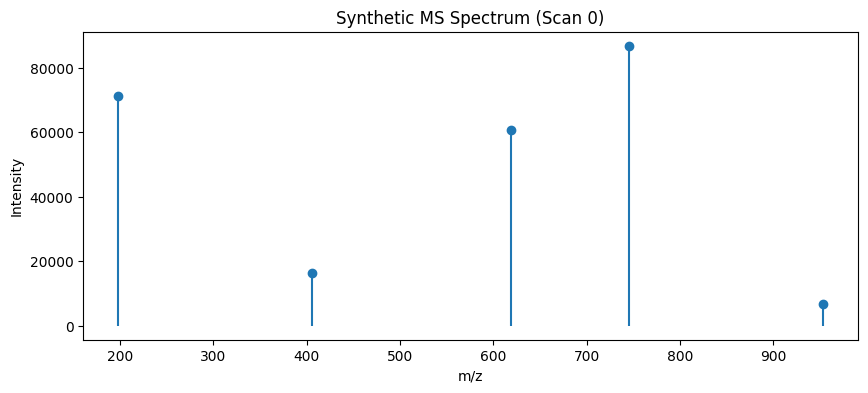

Classification Report:
              precision    recall  f1-score   support

           A       0.50      0.25      0.33         4
           B       0.25      0.50      0.33         2

    accuracy                           0.33         6
   macro avg       0.38      0.38      0.33         6
weighted avg       0.42      0.33      0.33         6

Confusion Matrix:
[[1 3]
 [1 1]]


In [5]:
# Visualize a single MS spectrum (e.g., scan 0)
scan_id = 0
spectrum = ms_df[ms_df['scan'] == scan_id]

plt.figure(figsize=(10, 4))
plt.stem(spectrum['mz'], spectrum['intensity'], basefmt=" ")  # Removed use_line_collection
plt.xlabel('m/z')
plt.ylabel('Intensity')
plt.title(f'Synthetic MS Spectrum (Scan {scan_id})')
plt.show()

# Simple peak picking: find the m/z with max intensity in each scan
peak_picked = ms_df.loc[ms_df.groupby('scan')['intensity'].idxmax()]
peak_picked = peak_picked[['scan', 'rt', 'mz', 'intensity']].reset_index(drop=True)

# Simulate two sample types by shifting m/z peaks for half the scans
type_labels = []
for scan in range(time_points):
    if scan < time_points // 2:
        ms_df.loc[ms_df['scan'] == scan, 'mz'] += 5  # Type A: shift peaks
        type_labels.append('A')
    else:
        type_labels.append('B')
peak_picked['sample_type'] = type_labels

# Feature: use the most intense m/z value per scan as input
X = peak_picked[['mz']].values
# Target: sample type
y = peak_picked['sample_type'].values

# Train/test split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Evaluation
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Simulate two sample types by shifting m/z peaks for half the scans
type_labels = []
for scan in range(time_points):
    if scan < time_points // 2:
        ms_df.loc[ms_df['scan'] == scan, 'mz'] += 5  # Type A: shift peaks
        type_labels.append('A')
    else:
        type_labels.append('B')
peak_picked['sample_type'] = type_labels

# Feature: use the most intense m/z value per scan as input
X = peak_picked[['mz']].values
# Target: sample type
y = peak_picked['sample_type'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Evaluation
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           A       0.50      0.25      0.33         4
           B       0.25      0.50      0.33         2

    accuracy                           0.33         6
   macro avg       0.38      0.38      0.33         6
weighted avg       0.42      0.33      0.33         6

Confusion Matrix:
[[1 3]
 [1 1]]


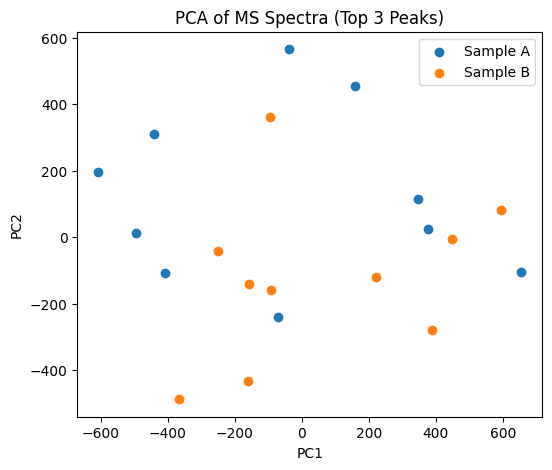

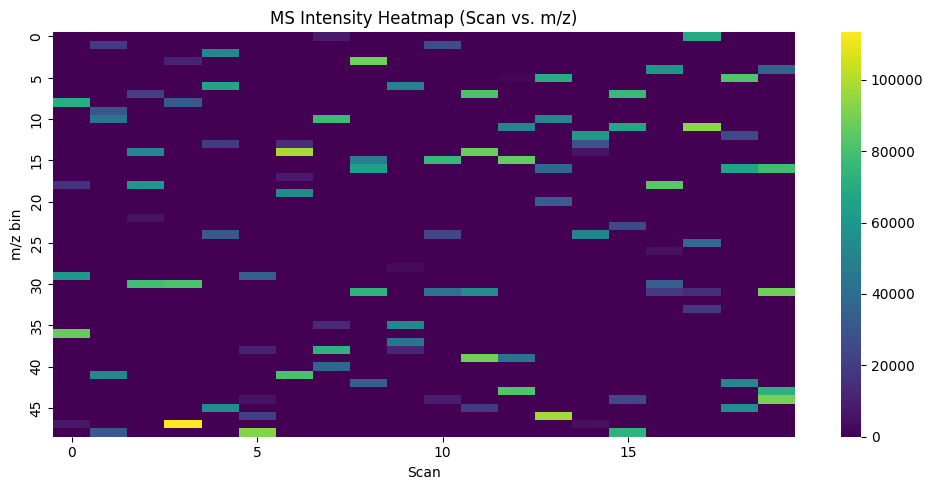

In [7]:
from sklearn.decomposition import PCA
import seaborn as sns

# --- Prepare feature matrix: use top N peaks per scan as features ---
N = 3  # Number of peaks per scan to use as features
features = []
for scan in range(time_points):
    scan_peaks = ms_df[ms_df['scan'] == scan].sort_values('intensity', ascending=False)
    top_mz = scan_peaks['mz'].values[:N]
    # Pad with zeros if fewer than N peaks
    if len(top_mz) < N:
        top_mz = np.pad(top_mz, (0, N - len(top_mz)), 'constant')
    features.append(top_mz)
features = np.array(features)

# --- PCA ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

plt.figure(figsize=(6, 5))
for label in np.unique(type_labels):
    idx = np.array(type_labels) == label
    plt.scatter(pca_result[idx, 0], pca_result[idx, 1], label=f'Sample {label}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of MS Spectra (Top 3 Peaks)')
plt.legend()
plt.show()

# --- Heatmap: Intensity vs. scan and m/z bins ---
mz_bins = np.linspace(mz_min, mz_max, 50)
scan_bins = np.arange(time_points + 1)
heatmap, xedges, yedges = np.histogram2d(ms_df['scan'], ms_df['mz'], bins=[scan_bins, mz_bins], weights=ms_df['intensity'])

plt.figure(figsize=(10, 5))
sns.heatmap(heatmap.T, cmap='viridis', xticklabels=5, yticklabels=5)
plt.xlabel('Scan')
plt.ylabel('m/z bin')
plt.title('MS Intensity Heatmap (Scan vs. m/z)')
plt.tight_layout()
plt.show()

### Interpreting the PCA of MS Spectra (Top 3 Peaks)

The PCA plot above visualizes each MS scan as a point in a 2D space, using the top 3 most intense m/z values from each scan as features. Points are colored by simulated sample type:

- **Sample A**: Scans where the top m/z peaks were shifted (simulating a different sample or condition)
- **Sample B**: Scans with unshifted peaks

This demonstrates how PCA can separate and cluster samples based on their spectral features, even with simple synthetic data. The approach is commonly used in MS data analysis for exploratory data analysis, quality control, and biomarker discovery.

In [8]:
# --- Batch mechanistic model fitting across all detected peaks ---
from collections import namedtuple

FitResult = namedtuple('FitResult', ['peak_idx', 'rt', 'D', 'v', 'scale', 'success'])
fit_results = []

for idx in peak_indices:
    # Window around each detected peak
    max_window = 40
    min_points = 10
    left = max(0, idx - max_window)
    right = min(len(time), idx + max_window)
    if right - left < min_points:
        expand = min_points - (right - left)
        left = max(0, left - expand // 2)
        right = min(len(time), right + expand - expand // 2)
    if right - left < min_points:
        left = max(0, idx - min_points // 2)
        right = min(len(time), idx + min_points // 2)
    if right - left < min_points:
        left = 0
        right = len(time)
    empirical_peak = chrom[left:right]
    empirical_time = time[left:right]
    
    def fit_dispersion(t, D, v, scale):
        sim = simulate_dispersion_odeint(t, D, v)
        return scale * sim
    try:
        if len(empirical_peak) == 0 or len(empirical_time) == 0:
            raise RuntimeError('No data for fitting')
        popt, _ = curve_fit(fit_dispersion, empirical_time, empirical_peak, p0=[0.1, 1.0, 1.0], bounds=([0,0,0],[5,5,10]))
        fit_results.append(FitResult(idx, time[idx], popt[0], popt[1], popt[2], True))
    except Exception as e:
        fit_results.append(FitResult(idx, time[idx], np.nan, np.nan, np.nan, False))

# Convert results to DataFrame for easy viewing
import pandas as pd
fit_results_df = pd.DataFrame(fit_results)
fit_results_df.columns = ['peak_idx', 'rt', 'D', 'v', 'scale', 'success']
fit_results_df


,peak_idx,rt,D,v,scale,success
0,102,2.044088,0.1,1.0,1.0,True
1,221,4.428858,0.1,1.0,1.0,True
2,253,5.070140,0.1,1.0,1.0,True
3,285,5.711423,0.1,1.0,1.0,True
4,343,6.873747,0.1,1.0,1.0,True
5,373,7.474950,0.1,1.0,1.0,True
6,404,8.096192,0.1,1.0,1.0,True


In [ ]:
# 1. Investigate peaks with unusual D or v values (outlier detection)
Q1 = fit_results_df[['D', 'v']].quantile(0.25)
Q3 = fit_results_df[['D', 'v']].quantile(0.75)
IQR = Q3 - Q1
outliers = fit_results_df[
    (fit_results_df['D'] < Q1['D'] - 1.5*IQR['D']) | (fit_results_df['D'] > Q3['D'] + 1.5*IQR['D']) |
    (fit_results_df['v'] < Q1['v'] - 1.5*IQR['v']) | (fit_results_df['v'] > Q3['v'] + 1.5*IQR['v'])
]
print('Outlier peaks (D or v outside 1.5x IQR):')
display(outliers)

# 2. Use fitted parameters for further modeling or ML
# Example: Use D and v as features for ML (dummy target for illustration)
X = fit_results_df[['D', 'v']].values
# y = ... (your target variable, e.g., sample type or pass/fail)
# Example: print features for downstream ML
print('Features for ML (D, v):')
print(X)

# 3. Integrate into automated QC: flag out-of-spec peaks
D_min, D_max = 0.1, 0.5
v_min, v_max = 1.0, 2.0
flagged = fit_results_df[
    (fit_results_df['D'] < D_min) | (fit_results_df['D'] > D_max) |
    (fit_results_df['v'] < v_min) | (fit_results_df['v'] > v_max)
]
if not flagged.empty:
    print("Warning: Some peaks have out-of-spec parameters!\n", flagged)
else:
    print("All peaks within expected parameter ranges.")

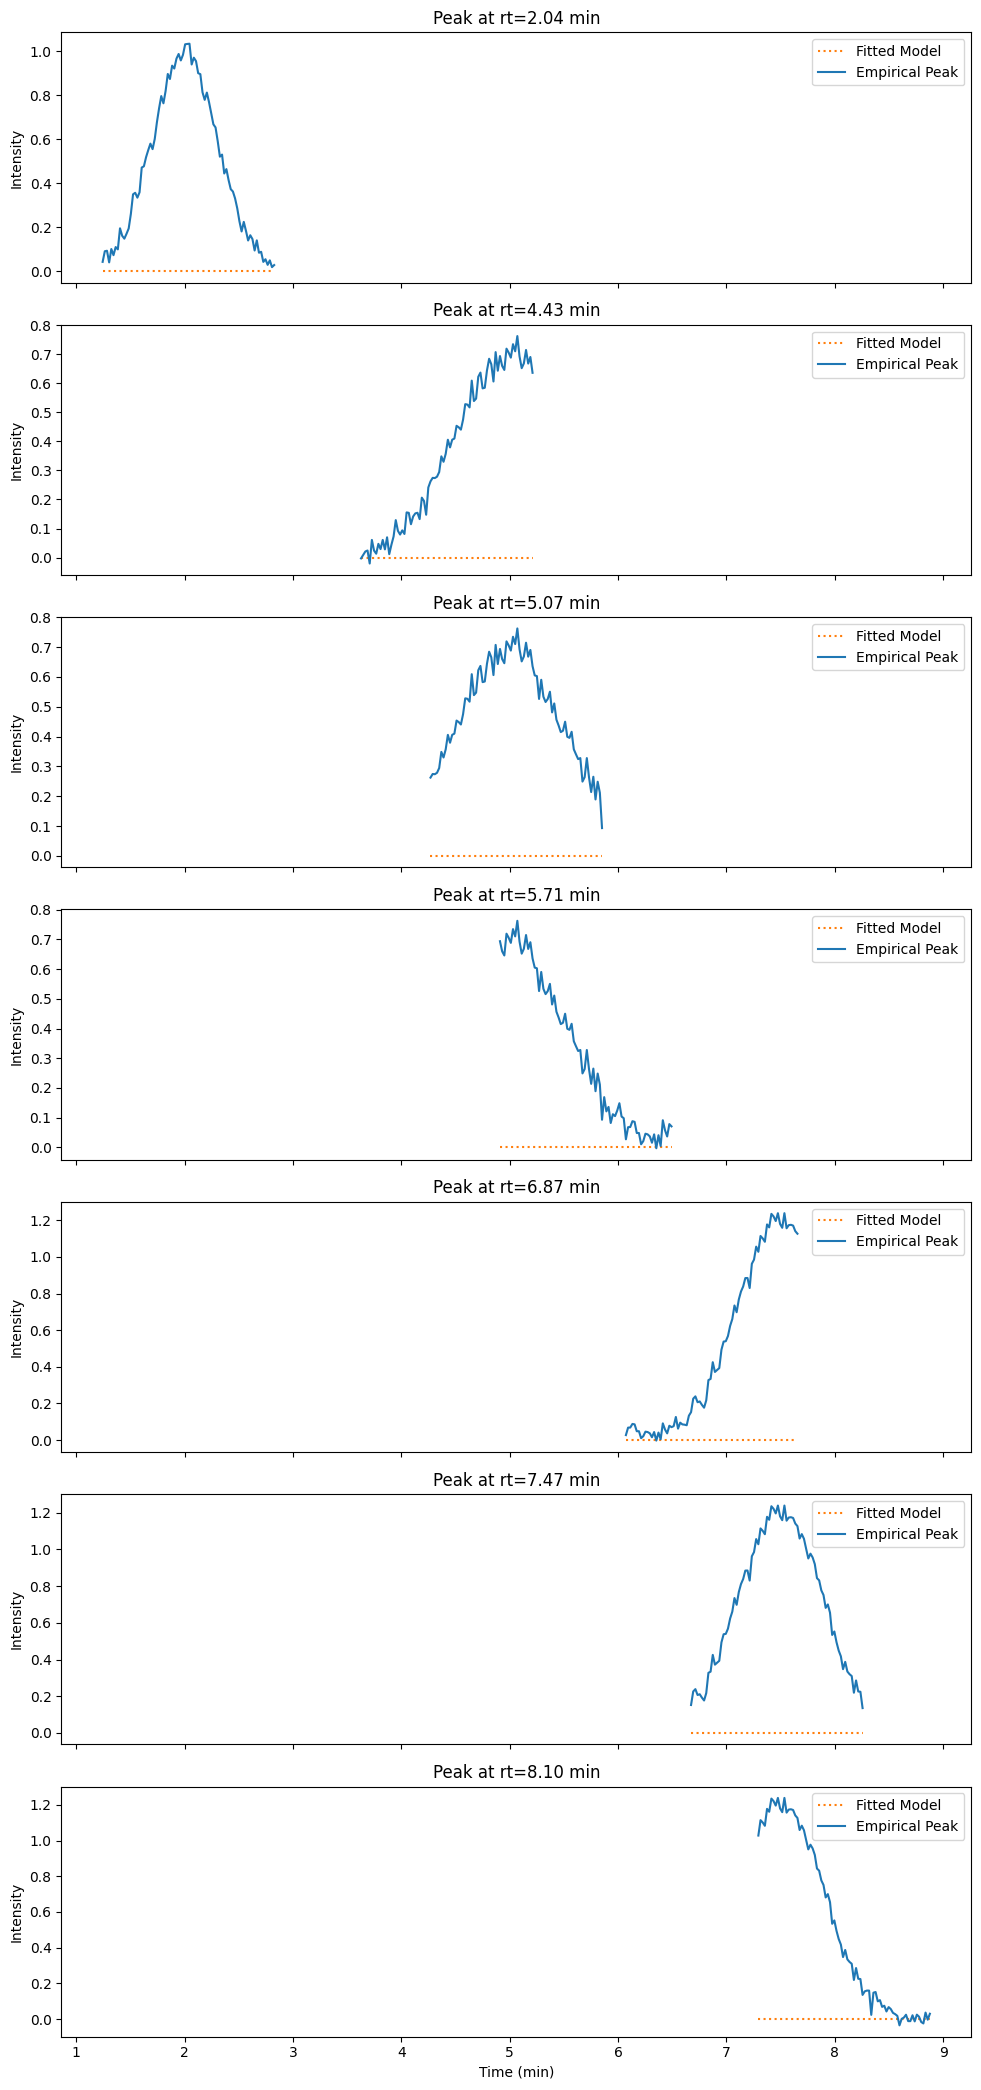

In [9]:
# --- Plot mechanistic model fits for each detected peak ---
num_peaks = len(peak_indices)
fig, axes = plt.subplots(num_peaks, 1, figsize=(10, 3*num_peaks), sharex=True)
if num_peaks == 1:
    axes = [axes]

for i, (idx, ax) in enumerate(zip(peak_indices, axes)):
    # Window around each detected peak (same as in batch fitting)
    max_window = 40
    min_points = 10
    left = max(0, idx - max_window)
    right = min(len(time), idx + max_window)
    if right - left < min_points:
        expand = min_points - (right - left)
        left = max(0, left - expand // 2)
        right = min(len(time), right + expand - expand // 2)
    if right - left < min_points:
        left = max(0, idx - min_points // 2)
        right = min(len(time), idx + min_points // 2)
    if right - left < min_points:
        left = 0
        right = len(time)
    empirical_peak = chrom[left:right]
    empirical_time = time[left:right]
    # Get fit parameters for this peak
    fit_row = fit_results_df[fit_results_df['peak_idx'] == idx]
    if not fit_row.empty and fit_row['success'].values[0]:
        D, v, scale = fit_row[['D', 'v', 'scale']].values[0]
        def fit_dispersion(t, D, v, scale):
            sim = simulate_dispersion_odeint(t, D, v)
            return scale * sim
        fitted = fit_dispersion(empirical_time, D, v, scale)
        ax.plot(empirical_time, fitted, ':', label='Fitted Model', color='tab:orange')
    ax.plot(empirical_time, empirical_peak, label='Empirical Peak', color='tab:blue')
    ax.set_ylabel('Intensity')
    ax.set_title(f'Peak at rt={time[idx]:.2f} min')
    ax.legend()
plt.xlabel('Time (min)')
plt.tight_layout()
plt.show()

### Batch Mechanistic Model Fitting: Interpretation and Discussion

The table above summarizes the mechanistic model fit parameters (dispersion D, velocity v, and scale) for each detected chromatographic peak. This batch fitting approach enables:

- **Peak-by-peak comparison:** Each peak's physical parameters can be compared, revealing differences in dispersion or flow that may indicate column heterogeneity, sample effects, or instrument variability.
- **Quality control:** Peaks with failed fits (see 'success' column) may indicate poor peak shape, overlapping peaks, or noise, highlighting areas for further review.
- **Automated reporting:** This approach supports high-throughput, reproducible analysis, as all detected peaks are processed identically.

**How to use these results:**
- Investigate peaks with unusual D or v values for possible chromatographic issues.
- Use the fitted parameters for further modeling, simulation, or as features in downstream ML workflows.
- Integrate this batch fitting into automated QC pipelines for routine chromatographic analysis.

This demonstrates how mechanistic modeling can be scaled to entire chromatograms, not just single peaks, providing deeper insight and supporting robust, automated informatics workflows.